In [1]:
from mpmath import sigmoid

from networks import *
from simulation import *

In [2]:
data = FinanceData()
data.download()
par = ParameterCalculator(rp=lambda _: 0.1, rr=data.market_rr)
par.compute_sentiment(0, 30, 200)
sentiment = par.get_sentiment()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


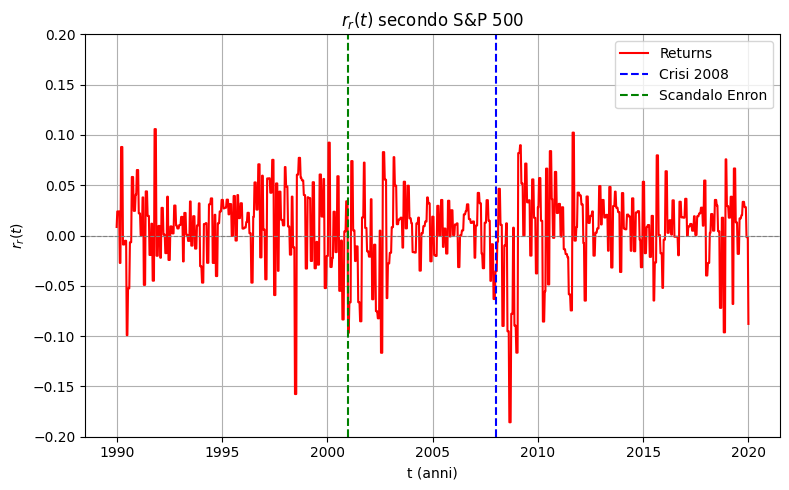

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create time values
t_plot = np.linspace(0, 30, 1000)

# Create the figure and axis (returns)
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot returns on the left y-axis
ax1.plot(t_plot + 1990, [par.rr(t) for t in t_plot], label="Returns", color="red")
ax1.set_xlabel("t (anni)")
ax1.set_ylabel(f"$r_r(t)$")
ax1.set_ylim(-0.2, 0.2)
ax1.tick_params(axis="y")
ax1.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Neutral line
ax1.grid(True)

# Add vertical lines for the events
ax1.axvline(x=2008, color='blue', linestyle='--', label='Crisi 2008')
ax1.axvline(x=2001, color='green', linestyle='--', label='Scandalo Enron')

# Title and legend
plt.title(f"$r_r(t)$ secondo S&P 500")
ax1.legend()

fig.tight_layout()

# Save the plot and show it
plt.savefig('imgs/madoff/returns.png')
plt.show()


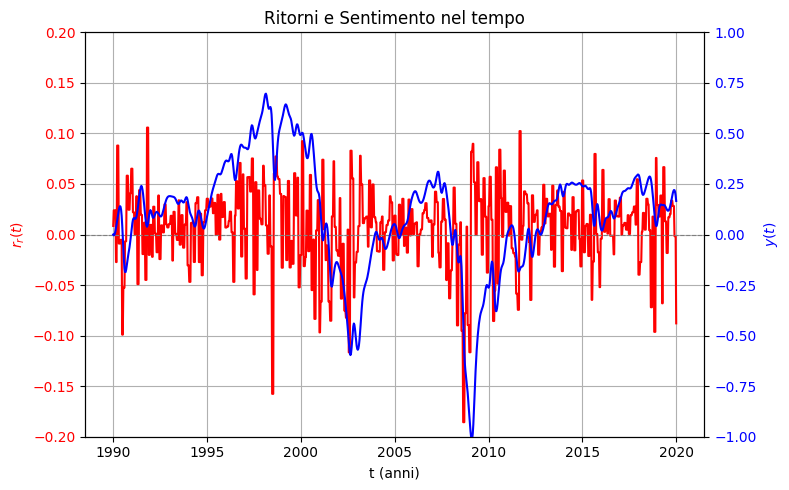

In [4]:


# Create the figure and first axis (returns)
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot returns on the left y-axis
ax1.plot(t_plot + 1990, [par.rr(t) for t in t_plot], label="Returns", color="red")
ax1.set_xlabel("t (anni)")
ax1.set_ylabel(f"$r_r(t)$", color="red")
ax1.set_ylim(-0.2, 0.2)
ax1.tick_params(axis="y", labelcolor="red")
ax1.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Neutral line
ax1.grid(True)

# Create second axis (sentiment)
ax2 = ax1.twinx()
ax2.ba_plot(t_plot + 1990, sentiment(t_plot), label=f"$y(t)$", color="blue")
ax2.set_ylabel(f"$y(t)$", color="blue")
ax2.set_ylim(-1, 1)
ax2.tick_params(axis="y", labelcolor="blue")

# Title and legend
plt.title("Ritorni e Sentimento nel tempo")
fig.tight_layout()
plt.savefig('imgs/madoff/sentiment.png')
plt.show()


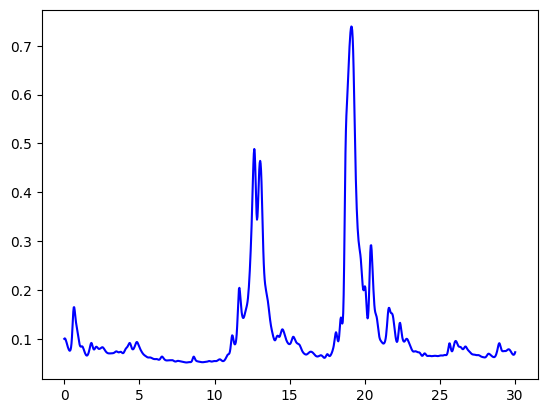

In [5]:
plt.plot(t_plot, [par.mu_from_rr(steepness=5)(t)  for t in t_plot], label="Mu", color="blue")

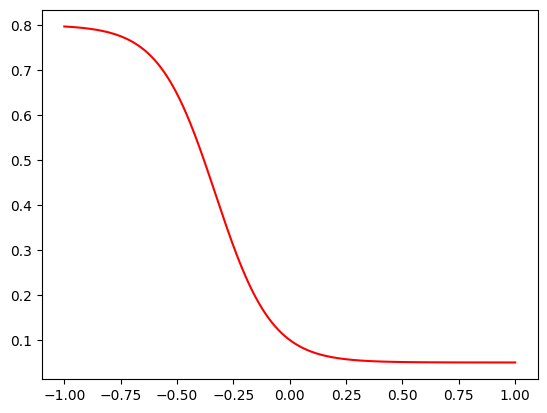

In [6]:
plt.plot(np.linspace(-1, 1, 1000), par._mu_from_sentiment(np.linspace(-1, 1, 1000), steepness=8), label="Sentiment", color="red")

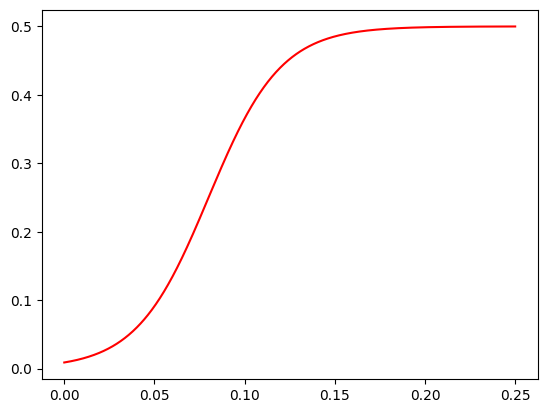

In [7]:
plt.plot(np.linspace(0, 0.25, 1000), par.extra_lambda_from_rp(np.linspace(0, 0.25, 1000)), label="Sentiment", color="red")

Cost for optimised solution: 5092051.039618196
Cost for non-optimal solution: 483466072.0296498


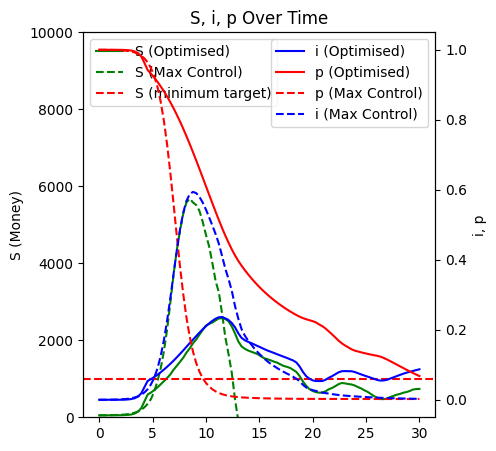

<Figure size 1000x600 with 0 Axes>

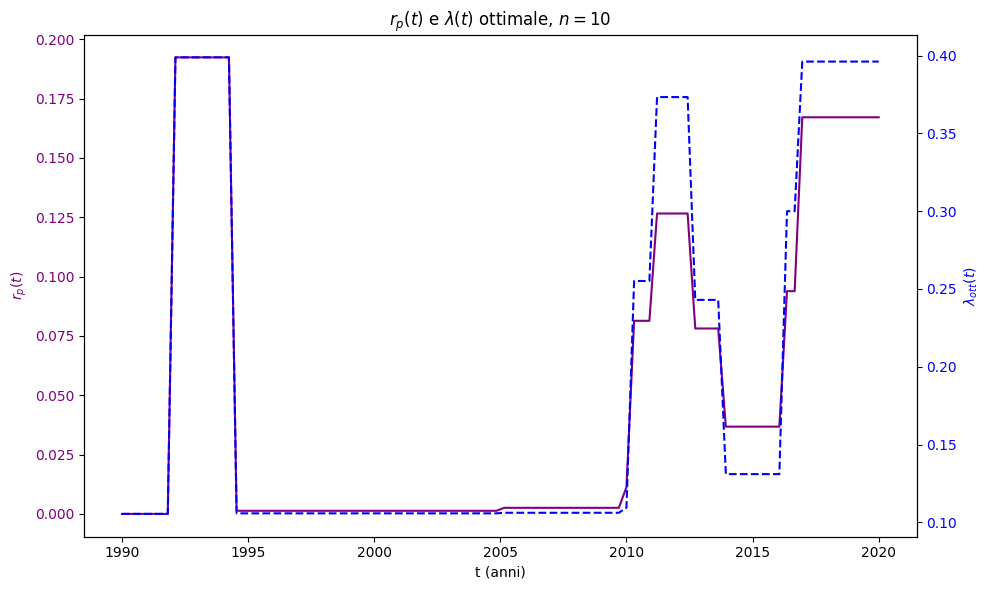

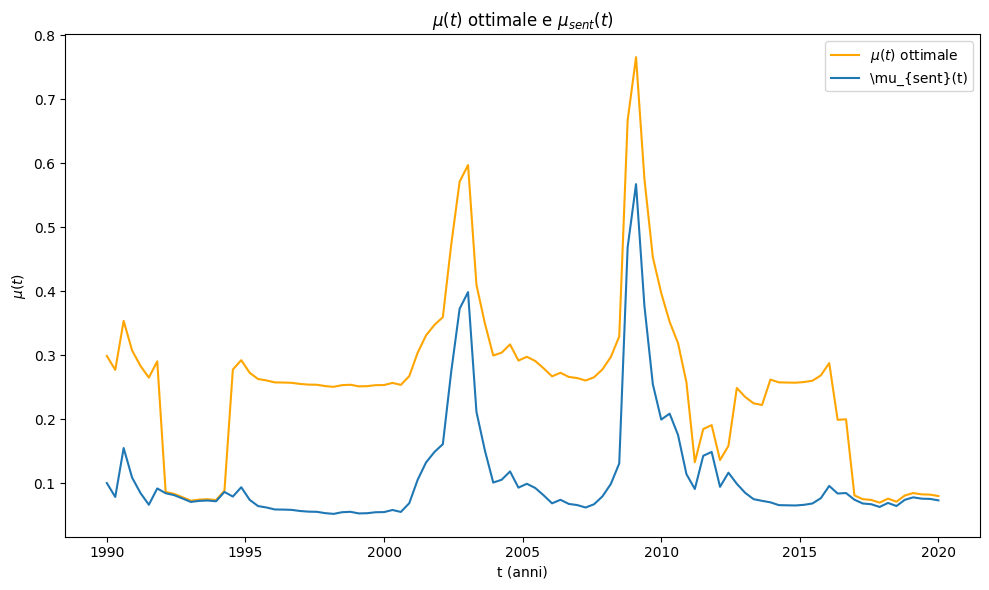

In [8]:
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution
from scipy.interpolate import CubicSpline

interest_calculator = ParameterCalculator(rp= lambda t: 0.15, rr= data.market_rr)
interest_calculator.compute_sentiment(0, 30, 200)
#interest_calculator.compute_sentiment(0, 30, 100, np.log(4) / 2)
num_switches =10
# Example, adjust as needed

#lambda_ = lambda _: 0.03#interest_calculator.lambda_from_rr_func(base=0.2, min=0.05, max=0.2, steepness=

u_min, u_max = 0, 0.2
def rp(u):
    return u#return 0.15#u_max#0.25
    #return u
u_fixed = 0.08

#def lambda_(u, t):
 #   0.1 + interest_calculator.extra_lambda_from_rp(u, max_lambda=0.1)#return u/u_max * 0.030#interest_calculator.lambda_from_rr_func(max=0.1, steepness=10)(t)
    #rp_ = rp(u)
    #return 0.05 + rp_/u_max * 0.05#rp / u_max * 0.04
    #np.where(0.03 * rp(t), )

M = 1  # Define constants if necessary
N = 10000
avg_k = 6

#mu = interest_calculator.mu_from_rr(min=0.05, base=0.1, max=0.8)
base_mu = interest_calculator.mu_from_rr(min=0.05, base=0.1, max=0.6)
mu = lambda u, t: base_mu(t) + interest_calculator.extra_mu_from_rp(u, base_rp=0.1, max_rp=u_max, max_mu=0.2)
lambda_ = lambda u, t: (0.1 + interest_calculator.extra_lambda_from_rp(u, max_rp=u_max, max_lambda=0.3))



def system_dynamics(t, y, u):
    i, p, S, U, C = y
    r_p = rp(u)
    lambda_eval = lambda_(u, t)
    mu_eval = mu(u, t)
    avg_w = U / C if C != 0 else 0

    di_dt = i * p * avg_k * lambda_eval - mu_eval * i
    dp_dt = -i * p * avg_k * lambda_eval
    dS_dt = (S * interest_calculator.rr(t) + M * N * lambda_eval * p * avg_k * i) - N * mu_eval * i * avg_w
    dU_dt = lambda_eval * avg_k * p * i * M + (r_p - mu_eval) * U
    dC_dt = lambda_eval * avg_k * p * i - mu_eval * C

    return [di_dt, dp_dt, dS_dt, dU_dt, dC_dt]

def optimal_control(params):
    """Generates the control function based on optimized switching times and values."""
    num_switches = len(params) // 2
    switching_times = np.sort(params[:num_switches])  # Ensure times are sorted
    switching_values = np.clip(params[num_switches:], u_min, u_max)  # Ensure values are within [u_min, u_max]

    def control_function(t):
        """Returns u(t) based on the switching schedule."""
        t = np.array(t)
        control_values = np.zeros_like(t)

        for i in range(num_switches - 1):
            mask = (t >= switching_times[i]) & (t < switching_times[i + 1])
            control_values[mask] = switching_values[i]

        control_values[t >= switching_times[-1]] = switching_values[-1]  # Last value

        return control_values

    return CubicSpline(t_span, control_function(t_span))


i0, p0, S0, U0, C0 = 1./N, 1 - 1./N, 50, 0, 0
t_span = np.linspace(0, 30, 100)
#print([interest_calculator.r_r(ti) for ti in t_span])

S_min = 1000
def lagrangian(y):
    i,p,S,U,C = y
    return np.where((S > S_min), 0, (S_min - S)**2)
   # return np.where((S > S_min), 0, S_min - S)
    #return -S/(N*M) + np.where((S > S_min), 0, 1)

def J(switching_times):
    global n_iter
    u = optimal_control(switching_times)
    sol = solve_ivp(lambda t, y: system_dynamics(t, y, u(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)

    i, p, S, U, C = sol.y
    #cost = np.sum(lagrangian(sol.y)) * (t_span[1] - t_span[0])

    #start_idx, stop_idx = find_range(S)
    #print('computed start, stop ', start_idx, stop_idx)
    #valid_range = sol.y[:, :]

    # Compute the cost only in the valid range
    #print('considered array is ', )
    #if (len(valid_range) == 0):
     #   return 0
    cost = np.sum(lagrangian(sol.y[:, :]) * (t_span[1] - t_span[0]))
    return cost

bounds = [(0, 30)] * num_switches + [(u_min, u_max)] * num_switches
sol = differential_evolution(J, bounds, strategy='best1bin', tol=1e-3, maxiter=50)
opt_switching_times = sol.x

u_opt = optimal_control(opt_switching_times)
sol_opt = solve_ivp(lambda t, y: system_dynamics(t, y, u_opt(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)
i_opt, p_opt, S_opt, U_opt, C_opt = sol_opt.y

u_always_max = optimal_control([0, u_fixed])
sol_max = solve_ivp(lambda t, y: system_dynamics(t, y, u_always_max(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)
i_max, p_max, S_max, U_max, C_max = sol_max.y

print(f'Cost for optimised solution: {J(opt_switching_times)}')
print(f'Cost for non-optimal solution: {J([0, u_fixed])}')

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(t_span, S_opt, label='S (Optimised)', color='green')
ax1.plot(t_span, S_max, label='S (Max Control)', color='green', linestyle='dashed')
ax1.axhline(S_min, color='red', linestyle='dashed', label='S (minimum target)')
ax1.set_ylim(0, 10000)
ax1.set_ylabel('S (Money)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.ba_plot(t_span, i_opt, label='i (Optimised)', color='blue')
ax2.ba_plot(t_span, p_opt, label='p (Optimised)', color='red')
ax2.ba_plot(t_span, p_max, label='p (Max Control)', color='red', linestyle='dashed')
#ax2.plot(t_span, p_opt, label='p (Optimised)', color='red')
ax2.ba_plot(t_span, i_max, label='i (Max Control)', color='blue', linestyle='dashed')
#ax2.plot(t_span, p_max, label='p (Max Control)', color='red', linestyle='dashed')
ax2.set_ylabel('i, p')
ax2.legend(loc='upper right')
plt.title('S, i, p Over Time')
plt.show()

plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primo asse y
ax1.plot(t_span + 1990, [u_opt(ti) for ti in t_span], label=r'$r_p$ ottimale', color='purple')
ax1.set_xlabel('t (anni)')
ax1.set_ylabel(r'$r_p(t)$', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Secondo asse y
ax2 = ax1.twinx()
ax2.ba_plot(t_span + 1990, [lambda_(u_opt(ti), ti) for ti in t_span], label=r'$\lambda_{ott}(t)$', color='blue', linestyle='dashed')
ax2.set_ylabel(r'$\lambda_{ott}(t)$', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Titolo e legenda
plt.title(r'$r_p(t)$ e $\lambda(t)$ ottimale, $n={}$'.format(num_switches))
fig.tight_layout()
fig.savefig('imgs/madoff_sim/rp_lambda_opt.png')
plt.show()

# plot mu
plt.figure(figsize=(10, 6))
plt.plot(t_span + 1990, [mu(u_opt(ti), ti) for ti in t_span], label=r'$\mu(t)$ ottimale', color='orange')
plt.plot(t_span + 1990, [base_mu(ti) for ti in t_span], label=r'\mu_{sent}(t)')
plt.xlabel('t (anni)')
plt.ylabel(r'$\mu(t)$')
plt.title(r'$\mu(t)$ ottimale e $\mu_{sent}(t)$')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/madoff_sim/mu_opt.png')
plt.show()



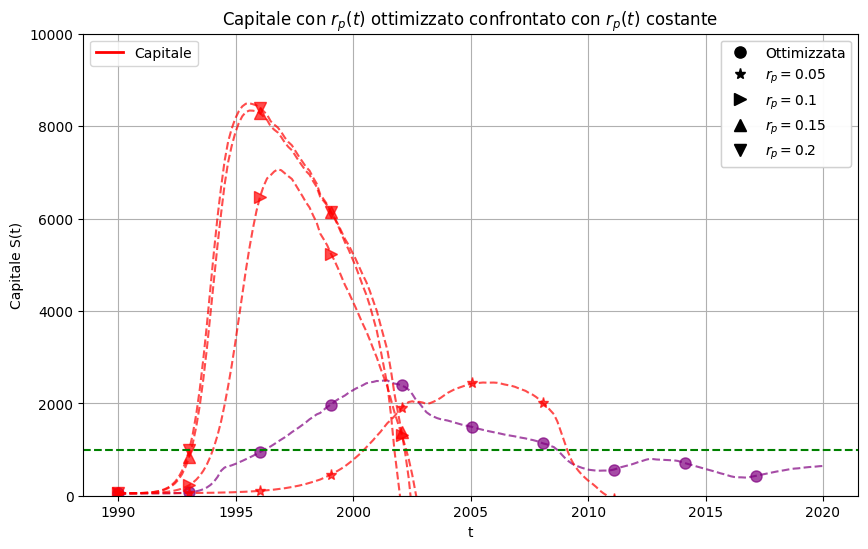

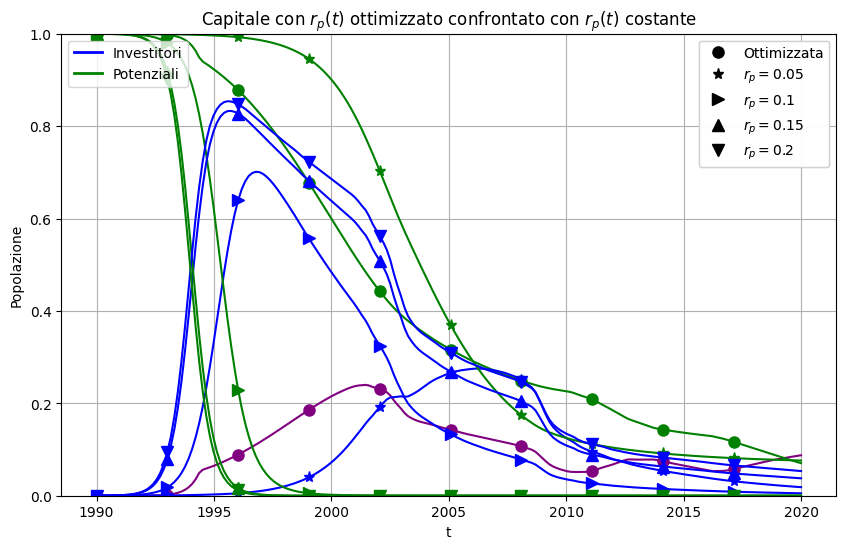

In [9]:
parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(u_opt(t), t), mu=lambda t: mu(u_opt(t), t), rp=lambda t: u_opt(t), rr=data.market_rr)
eq = DifferentialEquations(N=10000, ponzi_parameters=parameters, avg_k=6)
res = eq.solve(0, 30, 200)
plotter = PonziPlotter()
plotter.add_simulation(res,label='Ottimizzata', custom_color='purple')

for x in [0.05, 0.10, 0.15, 0.2]:
    parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(x, t), mu=lambda t: mu(x, t), rp=lambda t: x, rr=data.market_rr)
    eq = DifferentialEquations(N=10000, ponzi_parameters=parameters, avg_k=6)
    res = eq.solve(0, 30, 200)
    plotter.add_simulation(res,label=f'$r_p={x}$')

def add_Smin(ax: plt.Axes):
    ax.axhline(y=S_min, color='green', linestyle='dashed', label='$S_{min}= 1000$')

plotter.plot(file_name='madoff_sim/madoff_capitale', title=r'Capitale con $r_p(t)$ ottimizzato confrontato con $r_p(t)$ costante', show_capital=True, custom_func=add_Smin, offset=1990)
plotter.plot(file_name='madoff_sim/madoff_popolazione', title=r'Capitale con $r_p(t)$ ottimizzato confrontato con $r_p(t)$ costante',show_investor=True, show_potential=True, offset=1990)


In [10]:
opt_switching_times

array([2.62030513e+01, 1.51384378e+01, 2.10013888e+00, 2.27187393e+01,
       4.37542548e+00, 2.38682161e+01, 1.97728652e+01, 2.68468758e+01,
       2.02951204e+01, 2.09906900e+01, 1.92381331e-01, 1.31011991e-03,
       2.55717576e-03, 1.12339422e-02, 8.13720394e-02, 1.26582287e-01,
       7.81292797e-02, 3.67637167e-02, 9.38639962e-02, 1.67132651e-01])

In [ ]:
from networks import ErNetwork
net = ErNetwork.load_json('my_networks/er1.json')
# parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(u_opt(t), t), mu=lambda t: mu(u_opt(t), t), rp=u_opt, rr=interest_calculator.rr)
parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(u_opt(t), t), mu=lambda t: mu(u_opt(t), t), rp=lambda t: u_opt(t), rr=data.market_rr)

sim = PonziSimulation(net, parameters, max_time_units=12*30, dt=1./12)
res = sim.simulate_ponzi()

plotter = PonziPlotter()
plotter.add_simulation(res)
plotter.plot(show_capital=True, file_name='madoff_sim/madoff_capitale_net', title=r'Capitale con $r_p(t)$ su network ER',custom_func=add_Smin, offset=1990)

Network caricato da my_networks/er1.json
Starting simulation
5.00% complete
10.00% complete
15.28% complete


C:\Users\Torto\PycharmProjects\Ponzi-Scheme\simulation\parameters_calculator.py:19: IntegrationWarning: The maximum number of subdivisions (30) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return starting * np.exp(quad(self.rp, t1, t2, limit=30)[0])


20.28% complete
25.28% complete
30.28% complete
35.28% complete
40.28% complete
45.28% complete
50.28% complete


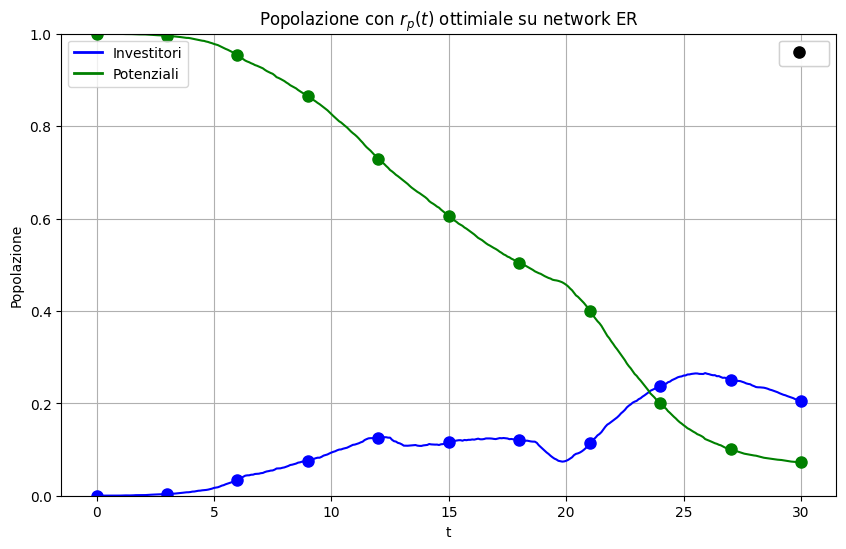

In [28]:
plotter.plot(show_investor=True, show_potential=True, file_name='madoff_sim/madoff_popolazione_net', title=r'Popolazione con $r_p(t)$ ottimiale su network ER',custom_func=add_Smin, offset=1990)


Network caricato da my_networks/ba1.json
Starting simulation
5.00% complete
10.00% complete
15.28% complete
20.28% complete
25.28% complete
30.28% complete
35.28% complete
40.28% complete
45.28% complete
50.28% complete
55.28% complete
60.56% complete
65.56% complete
70.56% complete
75.83% complete
80.83% complete
86.11% complete
91.39% complete
96.39% complete


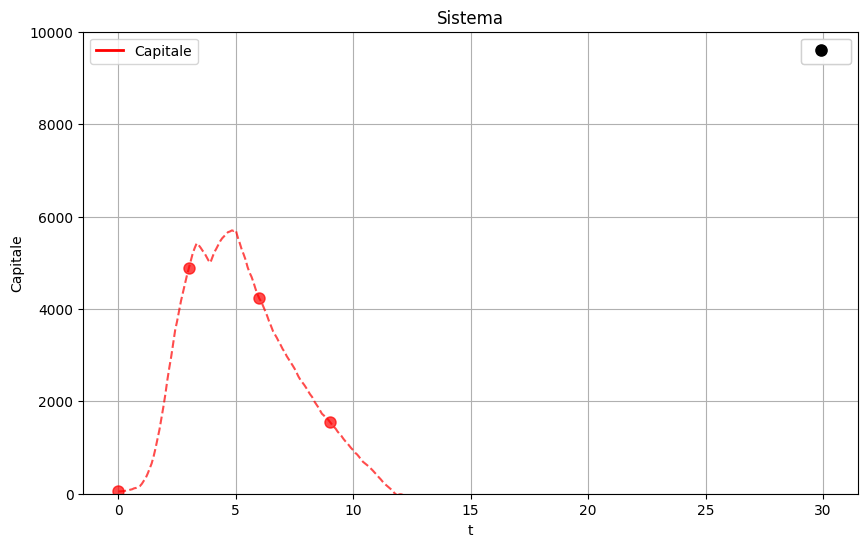

In [22]:
from networks import ErNetwork
net = ErNetwork.load_json('my_networks/ba1.json')
# parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(u_opt(t), t), mu=lambda t: mu(u_opt(t), t), rp=u_opt, rr=interest_calculator.rr)
parameters = PonziParameters(M=1, starting_capital=50, lambda_= lambda t: lambda_(u_opt(t), t), mu=lambda t: mu(u_opt(t), t), rp=lambda t: u_opt(t), rr=data.market_rr)

sim = PonziSimulation(net, parameters, max_time_units=12*30, dt=1./12)
res = sim.simulate_ponzi()

plotter = PonziPlotter()
plotter.add_simulation(res)
plotter.plot(show_capital=True)

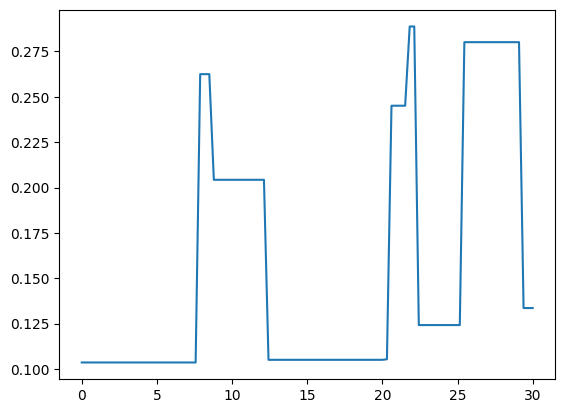

In [13]:
plt.plot(t_span, lambda_(u_opt(t_span), t_span))

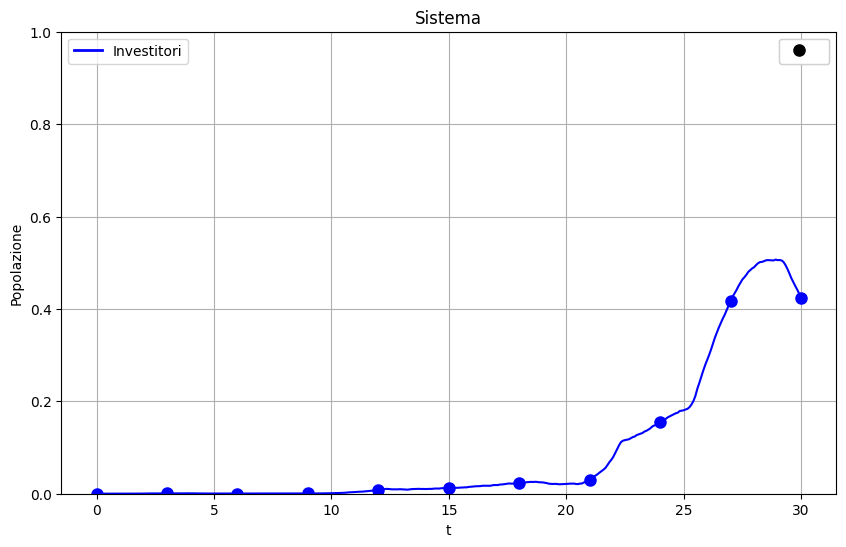

In [14]:
plotter.plot(show_investor=True)

In [15]:
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution

interest_calculator = ParameterCalculator(rp= lambda t: 0.15, rr= data.market_rr)
interest_calculator.compute_sentiment(0, 30, 200)
#interest_calculator.compute_sentiment(0, 30, 100, np.log(4) / 2)
num_switches = 10
# Example, adjust as needed

#lambda_ = lambda _: 0.03#interest_calculator.lambda_from_rr_func(base=0.2, min=0.05, max=0.2, steepness=

u_min, u_max = 0, 0.2
def rp(u):
    return u#return 0.15#u_max#0.25
    #return u
u_fixed = 0.08

def lambda_(u, t):
    0.1 + interest_calculator.extra_lambda_from_rp(u, max_lambda=0.1)#return u/u_max * 0.030#interest_calculator.lambda_from_rr_func(max=0.1, steepness=10)(t)
    #rp_ = rp(u)
    #return 0.05 + rp_/u_max * 0.05#rp / u_max * 0.04
    #np.where(0.03 * rp(t), )

M = 1  # Define constants if necessary
N = 10000
avg_k = 6

#mu = interest_calculator.mu_from_rr(min=0.05, base=0.1, max=0.8)
base_mu = interest_calculator.mu_from_rr(min=0.05, base=0.1, max=0.6)
mu = lambda u, t: base_mu(t) + interest_calculator.extra_mu_from_rp(u, base_rp=0.1, max_rp=u_max, max_mu=0.2)
lambda_ = lambda u, t: (0.1 + interest_calculator.extra_lambda_from_rp(u, max_rp=u_max, max_lambda=0.2))



def system_dynamics(t, y, u):
    i, p, S, U, C = y
    r_p = rp(u)
    lambda_eval = lambda_(u, t)
    mu_eval = mu(u, t)
    avg_w = U / C if C != 0 else 0

    di_dt = i * p * avg_k * lambda_eval - mu_eval * i
    dp_dt = -i * p * avg_k * lambda_eval
    dS_dt = (S * interest_calculator.rr(t) + M * N * lambda_eval * p * avg_k * i) - N * mu_eval * i * avg_w
    dU_dt = lambda_eval * avg_k * p * i * M + (r_p - mu_eval) * U
    dC_dt = lambda_eval * avg_k * p * i - mu_eval * C

    return [di_dt, dp_dt, dS_dt, dU_dt, dC_dt]


def optimal_control(params):
    """Generates the control function based on optimized switching times and values."""
    num_switches = len(params) // 2
    switching_times = np.sort(params[:num_switches])  # Ensure times are sorted
    switching_values = np.clip(params[num_switches:], u_min, u_max)  # Ensure values are within [u_min, u_max]

    def control_function(t):
        """Returns u(t) based on the switching schedule."""
        t = np.array(t)
        control_values = np.zeros_like(t)

        for i in range(num_switches - 1):
            mask = (t >= switching_times[i]) & (t < switching_times[i + 1])
            control_values[mask] = switching_values[i]

        control_values[t >= switching_times[-1]] = switching_values[-1]  # Last value

        return control_values

    return control_function


i0, p0, S0, U0, C0 = 1./N, 1 - 1./N, 50, 0, 0
t_span = np.linspace(0, 30, 100)
#print([interest_calculator.r_r(ti) for ti in t_span])

S_min = 1000
def lagrangian(y):
    i,p,S,U,C = y
    return np.where((S > S_min), 0, S_min - S)
   # return np.where((S > S_min), 0, S_min - S)
    #return -S/(N*M) + np.where((S > S_min), 0, 1)

n_iter =0
def J(switching_times):
    global n_iter
    u = optimal_control(switching_times)
    sol = solve_ivp(lambda t, y: system_dynamics(t, y, u(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)

    i, p, S, U, C = sol.y
    #cost = np.sum(lagrangian(sol.y)) * (t_span[1] - t_span[0])

    #start_idx, stop_idx = find_range(S)
    #print('computed start, stop ', start_idx, stop_idx)
    #valid_range = sol.y[:, :]

    # Compute the cost only in the valid range
    #print('considered array is ', )
    #if (len(valid_range) == 0):
     #   return 0
    cost = np.sum(lagrangian(sol.y[:, :]) * (t_span[1] - t_span[0]))
    #print('computed cost is ', cost)
    n_iter += 1
    return cost

bounds = [(0, 30)] * num_switches + [(u_min, u_max)] * num_switches
sol = differential_evolution(J, bounds, strategy='best1bin', tol=1e-3, maxiter=10)
opt_switching_times = sol.x

u_opt = optimal_control(opt_switching_times)
sol_opt = solve_ivp(lambda t, y: system_dynamics(t, y, u_opt(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)
i_opt, p_opt, S_opt, U_opt, C_opt = sol_opt.y

u_always_max = optimal_control([0, u_fixed])
sol_max = solve_ivp(lambda t, y: system_dynamics(t, y, u_always_max(t)), (0, 30), [i0, p0, S0, U0, C0], t_eval=t_span)
i_max, p_max, S_max, U_max, C_max = sol_max.y

print(f'Cost for optimised solution: {J(opt_switching_times)}')
print(f'Cost for non-optimal solution: {J([0, u_fixed])}')

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(t_span, S_opt, label='S (Optimised)', color='green')
ax1.plot(t_span, S_max, label='S (Max Control)', color='green', linestyle='dashed')
ax1.axhline(S_min, color='red', linestyle='dashed', label='S (minimum target)')
ax1.set_ylim(0, 10000)
ax1.set_ylabel('S (Money)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.ba_plot(t_span, i_opt, label='i (Optimised)', color='blue')
ax2.ba_plot(t_span, p_opt, label='p (Optimised)', color='red')
ax2.ba_plot(t_span, p_max, label='p (Max Control)', color='red', linestyle='dashed')
ax2.ba_plot(t_span, i_max, label='i (Max Control)', color='blue', linestyle='dashed')
ax2.set_ylabel('i, p')
ax2.legend(loc='upper right')
plt.title('S, i, p Over Time')

# Save the first figure
plt.tight_layout()
plt.savefig('imgs/madoff_sim/fig_S_i_p.png')
plt.close()  # Close the figure to avoid overlapping with the next plot

# Plot Control u Over Time
plt.figure(figsize=(10, 5))
plt.plot(t_span, [u_opt(ti) for ti in t_span], label='u_opt', color='purple')
plt.plot(t_span, [u_always_max(ti) for ti in t_span], label='Max control', color='purple', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Control')
plt.title('Control u Over Time')
plt.legend()

# Save the second figure
plt.tight_layout()
plt.savefig('imgs/madoff_sim/fig_control_u.png')
plt.close()

# Plot Mu and Lambda Over Time
plt.figure(figsize=(10, 5))

# Plot mu over time
plt.subplot(1, 2, 1)
mu_vals = [mu(u_opt(ti), ti) for ti in t_span]
plt.plot(t_span, mu_vals, label=r'$\mu(t)$ with extra', color='orange')
plt.plot(t_span, [base_mu(ti) for ti in t_span], label='base mu')
plt.xlabel('Time')
plt.ylabel(r'$\mu(t)$')
plt.title('Mu Over Time')
plt.legend()

# Plot lambda over time
plt.subplot(1, 2, 2)
lambda_vals = [lambda_(u_opt(ti), ti) for ti in t_span]
plt.plot(t_span, lambda_vals, label=r'$\lambda(t)$', color='red')
plt.xlabel('Time')
plt.ylabel(r'$\lambda(t)$')
plt.title('Lambda Over Time')
plt.legend()

# Save the third figure
plt.tight_layout()
plt.savefig('imgs/madoff_sim/fig_mu_lambda.png')
plt.close()



Cost for optimised solution: 9120.467256469201
Cost for non-optimal solution: 63776.939189625235


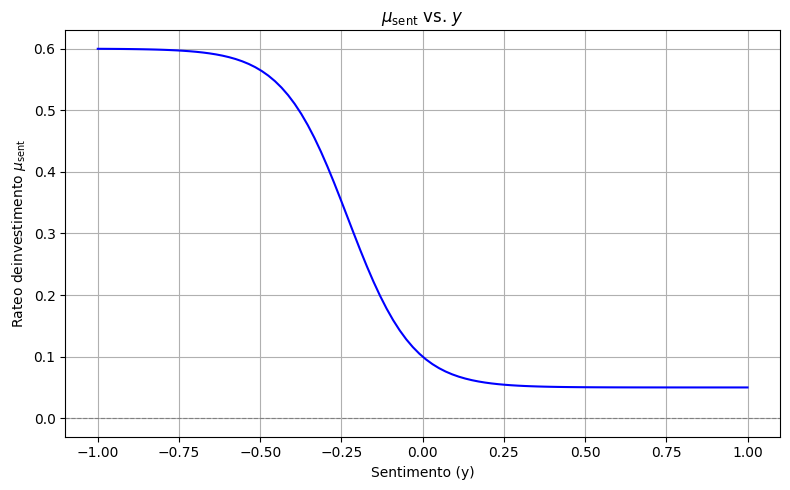

In [16]:
# Generate x values (sentiment values)
x_space = np.linspace(-1, 1, 100)

# Compute mu values using the function
mu_values = [interest_calculator._mu_from_sentiment(sent=x, steepness=10, min=0.05, base=0.1, max=0.6) for x in x_space]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x_space, mu_values, color="blue")

# Add labels and title
plt.xlabel("Sentimento (y)")
plt.ylabel(r"Rateo deinvestimento $\mu_{\text{sent}}$")
plt.title(r"$\mu_{\text{sent}}$ vs. $y$")

# Add grid and legend
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line
#plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('imgs/madoff/mu_sent_vs_y.png')
plt.show()

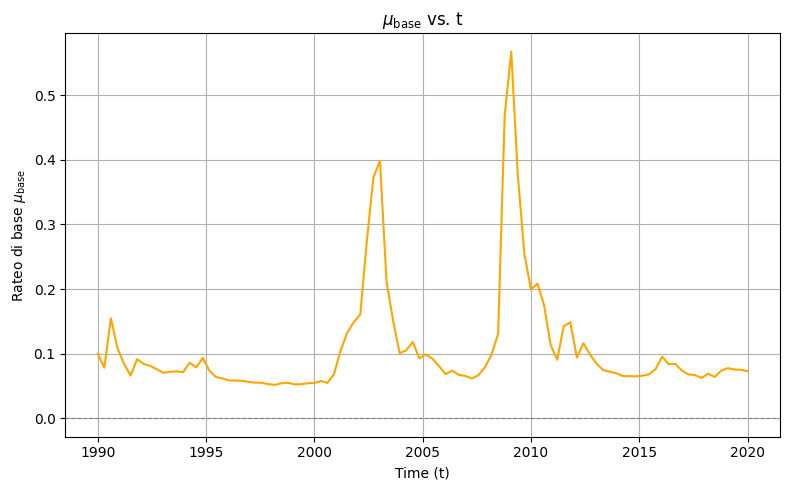

In [17]:
# Generate time values (from 0 to 30)
time_values = np.linspace(0, 30, 100)

# Compute mu_base values using the function
mu_base_values = [interest_calculator.mu_from_rr(min=0.05, base=0.1, max=0.6)(t) for t in time_values]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(time_values + 1990, mu_base_values, color="orange")

# Add labels and title
plt.xlabel("Time (t)")
plt.ylabel(r"Rateo di base $\mu_{\text{base}}$")
plt.title(r"$\mu_{\text{base}}$ vs. t")

# Add grid and reference line
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('imgs/madoff/mu_base_vs_time.png')
plt.show()


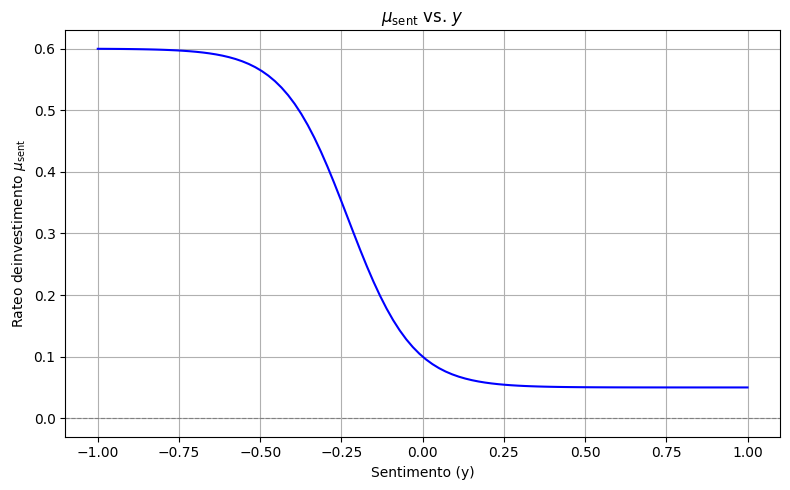

In [18]:
# Generate x values (sentiment values)
x_space = np.linspace(-1, 1, 100)

# Compute mu values using the function
mu_values = [interest_calculator._mu_from_sentiment(sent=x, steepness=10, min=0.05, base=0.1, max=0.6) for x in x_space]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x_space, mu_values, color="blue")

# Add labels and title
plt.xlabel("Sentimento (y)")
plt.ylabel(r"Rateo deinvestimento $\mu_{\text{sent}}$")
plt.title(r"$\mu_{\text{sent}}$ vs. $y$")

# Add grid and legend
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line
#plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('imgs/madoff/mu_sent_vs_y.png')
plt.show()

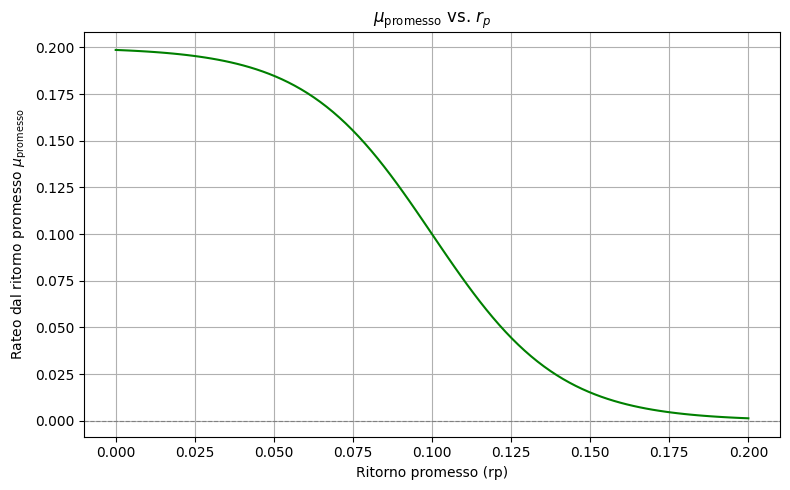

In [19]:
# Generate x values (return values)
x_space = np.linspace(u_min, u_max, 100)

# Compute mu values using the function
mu_promesso_values = [interest_calculator.extra_mu_from_rp(x, base_rp=0.1, max_rp=u_max, max_mu=0.2) for x in x_space]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x_space, mu_promesso_values, color="green")

# Add labels and title
plt.xlabel("Ritorno promesso (rp)")
plt.ylabel(r"Rateo dal ritorno promesso $\mu_{\text{promesso}}$")
plt.title(r"$\mu_{\text{promesso}}$ vs. $r_p$")

# Add grid and reference line
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig('imgs/madoff/mu_promesso_vs_rp.png')
plt.show()


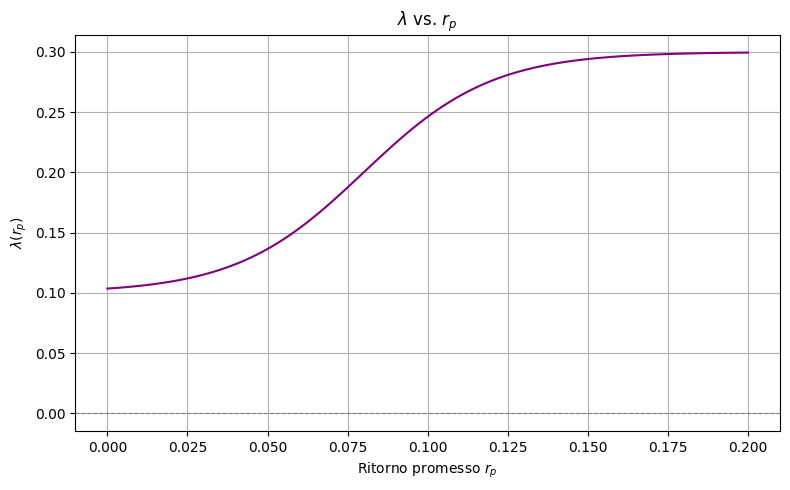

In [20]:
# Generate x values (return values)
x_space = np.linspace(u_min, u_max, 100)

# Compute lambda values using the function
lambda_values = [0.1 + interest_calculator.extra_lambda_from_rp(x, max_rp=u_max, max_lambda=0.2) for x in x_space]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x_space, lambda_values, color="purple")

# Add labels and title
plt.xlabel("Ritorno promesso $r_p$")
plt.ylabel(r"$\lambda (r_p)$")
plt.title(r"$\lambda$ vs. $r_p$")

# Add grid and reference line
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig('imgs/madoff/lambda_vs_rp.png')
plt.show()
